# **Import all the necessary libraries:**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as Func
import torch.utils
import torch.distributions
import torchvision
import torchvision.datasets as datasetLoader
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


# **Use GPU as accelerator if available:**

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
lr_rate = 0.001

cuda


# **Load the necessary data and pre-process them:**

In [3]:
#load the unlabelled dataset:
test_dataset = datasetLoader.ImageFolder(root='test/',
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))

#load the labelled datasets:
dataset = datasetLoader.ImageFolder(root='train/',
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))

labels_dict = {v:k for k, v in dataset.class_to_idx.items()}

#weightedRandomSampler to counter class imbalance:
def sampler_func(dataset):
    class_weight = [0.4, 0.4, 0.4, 1]
    sample_weight = []
    for (data, label) in dataset:
        sample_weight.append(class_weight[label])
    sampler = torch.utils.data.WeightedRandomSampler(weights = sample_weight, 
                                                     num_samples = len(sample_weight), 
                                                     replacement = True)
    return sampler

#split dataset into training and validation:
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size

train_dataset, validation_dataset =  torch.utils.data.random_split(dataset, 
                                             [train_size, validation_size], 
                                             generator=torch.Generator().manual_seed(2019))

#dataloader for train and validation datasets:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size = 256, 
                                               sampler = sampler_func(train_dataset))
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, 
                                              batch_size = 256, 
                                              sampler = sampler_func(validation_dataset))

#dataloader for test dataset:
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size = 256)


# **Function for plotting validation loss:**

In [4]:
#plot loss graph for each epoch:

def plot_loss(epoch_no, validation_loss_list, train_loss_list):
    x_axis_value = [i for i in range(1,epoch_no+1,1)]
    plt.plot(x_axis_value, validation_loss_list, label='Validation Loss')
    plt.plot(x_axis_value, train_loss_list, label='Train Loss')
    plt.xticks(range(1,epoch_no+1,1))
    plt.title("Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# **Function for plotting validation accuracy:**

In [5]:
#plot acc graph for each epoch:

def plot_acc(epoch_no, validation_acc_list, train_acc_list):
    x_axis_value = [i for i in range(1,epoch_no+1,1)]
    plt.plot(x_axis_value, validation_acc_list, label='Validation Accuracy')
    plt.plot(x_axis_value, train_acc_list, label='Train Accuracy')
    plt.xticks(range(1,epoch_no+1,1))
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy %')
    plt.legend()
    plt.show()

# **Function for display the Confusion Matrix:**

In [6]:
#confusion matrix:

def classifier_confusion_matrix(true_label, pred_label, label_dict, title):
    label_list = [label_dict[i] for i in range(0,4)]
    con_mat = confusion_matrix(true_label, pred_label, labels = [0,1,2,3])
    print(con_mat)
    figure = plt.figure()
    ax = figure.add_subplot(111)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    con_mat_ax = ax.matshow(con_mat)
    figure.colorbar(con_mat_ax)
    plt.title(title)
    ax.set_xticklabels([''] + label_list)
    ax.set_yticklabels([''] + label_list)
    plt.show()

# **Define a CNN model:**

In [7]:
#define the basic CNN:

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=16, 
                               kernel_size=3,
                               stride=1,
                               padding = 1)
        self.conv2 = nn.Conv2d(in_channels=16,
                               out_channels=32,
                               kernel_size=3,
                               stride=1,
                               padding = 1)
        self.maxPool = nn.MaxPool2d(kernel_size=2,
                                    stride = 2)
        self.linear1 = nn.Linear(in_features=32*16*16,
                                 out_features=4096)
        self.linear2 = nn.Linear(in_features=4096, 
                                 out_features=2048)
        self.linear3 = nn.Linear(in_features=2048,
                                 out_features=1024)
        self.linear4 = nn.Linear(in_features=1024,
                                 out_features=512)
        self.linear5 = nn.Linear(in_features=512,
                                 out_features=256)
        self.linear6 = nn.Linear(in_features=256,
                                 out_features=100)
        self.linear7 = nn.Linear(in_features=100,
                                 out_features=50)
        self.linear8 = nn.Linear(in_features=50,
                                 out_features=4)
        
    def forward(self, input):
        x = self.conv1(input)
        x = Func.relu(x)
        x = self.conv2(x)
        x = Func.relu(x)
        x = self.maxPool(x)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = Func.relu(x)
        x = self.linear2(x)
        x = Func.relu(x)
        x = self.linear3(x)
        x = Func.relu(x)
        x = self.linear4(x)
        x = Func.relu(x)
        x = self.linear5(x)
        x = Func.relu(x)
        x = self.linear6(x)
        x = Func.relu(x)
        x = self.linear7(x)
        x = Func.relu(x)
        x = self.linear8(x)
        return x

# **Define optimizer and loss function for CNN model:**

In [8]:
#defining the optimizer and loss function:
cnn_model = ConvNet().to(device)
cnn_adam_optimizer = optim.Adam(cnn_model.parameters(), lr = lr_rate)
cnn_loss_func = nn.CrossEntropyLoss()

# **Define the training fucntion for CNN model:**

In [9]:
# the training function:

def train_loop(n_epochs, optimizer, model, device, loss_fn, train_loader, validator, validation_dataloader):
    model = model.to(device)
    validation_loss_list = []
    validation_acc_list = []
    train_loss_list = []
    train_acc_list = []
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        print('Epoch {}, Training loss {}'.format(epoch, float(train_loss)))
        validation_loss, validation_acc = validator(model,
                                                     device,
                                                     validation_dataloader)
        train_loss, train_acc = validator(model,
                                          device,
                                          train_dataloader)
        validation_loss_list.append(validation_loss)
        validation_acc_list.append(validation_acc)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        
    return validation_loss_list, validation_acc_list, train_loss_list, train_acc_list

# **Define the test function for the CNN model:**

In [10]:
#the test function:

def test_loop(model, device, test_loader):
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += Func.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, 
                                                                                 correct, 
                                                                                 len(test_loader.dataset), 
                                                                                 100. * correct / len(test_loader.dataset)))
    return test_loss,  (100. * correct / len(test_loader.dataset))

# **Train and Validate the CNN model:**

In [11]:
#call training and test functions

cnn_validation_loss_list, cnn_validation_acc_list, cnn_train_loss_list, cnn_train_acc_list = train_loop(50,
                                                                                                       cnn_adam_optimizer,
                                                                                                       cnn_model,
                                                                                                       device,
                                                                                                       cnn_loss_func,
                                                                                                       train_dataloader,
                                                                                                       test_loop,
                                                                                                       validation_dataloader)


Epoch 1, Training loss 8.32935118675232

Test set: Average loss: 0.0264, Accuracy: 71/340 (21%)


Test set: Average loss: 0.0115, Accuracy: 357/1360 (26%)

Epoch 2, Training loss 7.95897912979126

Test set: Average loss: -0.2226, Accuracy: 87/340 (26%)


Test set: Average loss: -0.2635, Accuracy: 341/1360 (25%)

Epoch 3, Training loss 7.8724445104599

Test set: Average loss: -0.1977, Accuracy: 86/340 (25%)


Test set: Average loss: -0.2241, Accuracy: 342/1360 (25%)

Epoch 4, Training loss 7.104759573936462

Test set: Average loss: -0.4677, Accuracy: 170/340 (50%)


Test set: Average loss: -0.4540, Accuracy: 661/1360 (49%)

Epoch 5, Training loss 6.29179322719574

Test set: Average loss: -0.9962, Accuracy: 166/340 (49%)


Test set: Average loss: -0.8098, Accuracy: 641/1360 (47%)

Epoch 6, Training loss 6.041377663612366

Test set: Average loss: -2.8908, Accuracy: 175/340 (51%)


Test set: Average loss: -2.8681, Accuracy: 674/1360 (50%)

Epoch 7, Training loss 5.3869253396987915

Test se

# **Plot the validation loss and accuracy for CNN model:**

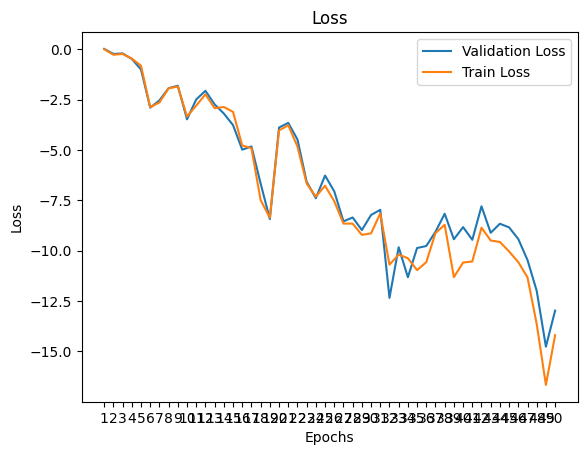

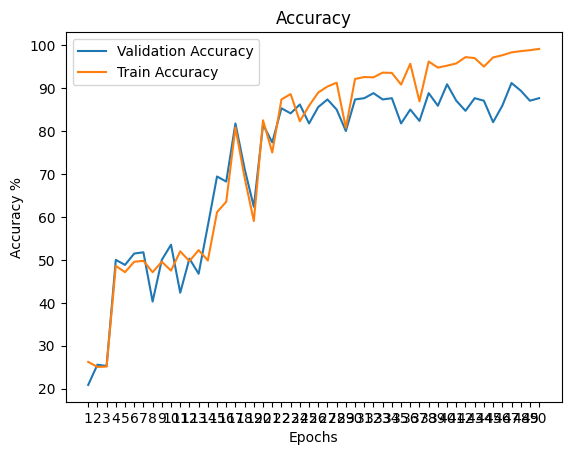

In [12]:
#plot cnn validation loss graph:
plot_loss(50, cnn_validation_loss_list, cnn_train_loss_list)

#plot cnn validation acc graph:
plot_acc(50, cnn_validation_acc_list, cnn_train_acc_list)

# **Plot the Confusion Matrix for the CNN model on Validation data:**

[[ 86   7   0   5]
 [  6 101   1   3]
 [  0   4  95   0]
 [  3   5   0  24]]


C:\Users\karthik\AppData\Local\Temp\ipykernel_11244\367963129.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_list)
C:\Users\karthik\AppData\Local\Temp\ipykernel_11244\367963129.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_list)


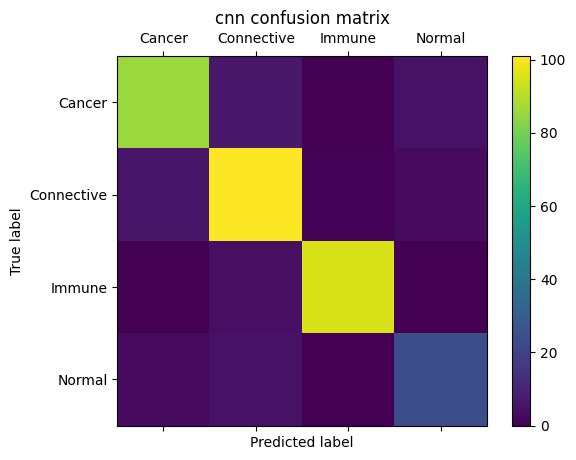

In [13]:
#print cnn confusion matrix:

cnn_true_label = []
cnn_pred_label = []
#get the true label and predicted label and send it to
#the confusion matrix function.
for data, label in validation_dataset:
    data = data.reshape(1,3,32,32)
    pred_label = torch.argmax(cnn_model(data.to(device)), 1)
    cnn_true_label.append(label)
    cnn_pred_label.append(pred_label.to('cpu').numpy()[0])
classifier_confusion_matrix(cnn_true_label, 
                            cnn_pred_label, 
                            labels_dict, 
                            'cnn confusion matrix')

# **Define the Autoencoder model:**

In [14]:
#autoencoder model:

#encoder:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(ConvEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3,
                               out_channels=16,
                               kernel_size=3,
                               stride=1,
                               padding = 1)
        self.conv2 = nn.Conv2d(in_channels=16,
                               out_channels=32, 
                               kernel_size=3,
                               stride=1,
                               padding = 1)
        self.maxPool = nn.MaxPool2d(kernel_size=2,
                                    stride = 2,
                                   padding=0,
                                   return_indices=True)
        self.linear1 = nn.Linear(in_features=32*16*16,
                                 out_features=latent_dims)
    
    def forward(self, input):
        #print(f"The shape of the input: {input.shape}" )
        x = self.conv1(input)
        x = Func.relu(x)
        #print(f"After first conv2d: {x.shape}" )
        x = self.conv2(x)
        x = Func.relu(x)
        #print(f"After second conv2d: {x.shape}" )
        x, maxpool_indices = self.maxPool(x)
        #print(f"After maxpool2d: {x.shape}" )
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        return x, maxpool_indices
        

#decoder:
class ConvDecoder(nn.Module):
    def __init__(self, latent_dims):
        super(ConvDecoder, self).__init__()
        self.linear1 = nn.Linear(in_features=latent_dims, 
                                 out_features=32*16*16)
        self.unflatten = nn.Unflatten(1, (32, 16, 16))
        self.unmaxpool = nn.MaxUnpool2d(kernel_size=2,
                                       stride=2)
        self.deconv1 = nn.ConvTranspose2d(in_channels=32,
                                          out_channels=16, 
                                          kernel_size=3, 
                                          stride = 1,
                                          padding=1)
        self.deconv2 = nn.ConvTranspose2d(in_channels=16,
                                          out_channels=3, 
                                          kernel_size=3, 
                                          stride = 1,
                                          padding=1)
        
    def forward(self, latent_vector, maxpool_indices):
        x = self.linear1(latent_vector)
        x = Func.relu(x)
        x = self.unflatten(x)
        x = self.unmaxpool(x, maxpool_indices)
        x = self.deconv1(x)
        x = Func.relu(x)
        x = self.deconv2(x)
        x = torch.sigmoid(x)
        return x
    

#autoencoder:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = ConvEncoder(latent_dims)
        self.decoder = ConvDecoder(latent_dims)
    
    def forward(self, input):
        latent_vector, maxpool_indices = self.encoder(input)
        return self.decoder(latent_vector, maxpool_indices)


# **Define the optimizer and loss function for the Autoencoder model:**

In [15]:
autoencoder_model = Autoencoder(latent_dims = 1024).to(device)
autoencoder_adam_optimizer = optim.Adam(autoencoder_model.parameters(), lr = lr_rate)
mse_loss_func = nn.MSELoss()

# **Define the training function for the Autoencoder:**

In [16]:
#training for autoencoder on test dataset:

def train_autoencoder(autoencoder, data, opt, loss_fn, epochs=20):
    for epoch in range(1, epochs+1):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = loss_fn(x, x_hat)
            loss.backward()
            opt.step()
        print (f'Train epoch:{epoch} with previous loss {loss}');
    return autoencoder

# **Train and Validate the Autoencoder:**

In [17]:
#print(autoencoder_model.encoder)
trained_autoencoder = train_autoencoder(autoencoder_model, 
                                        test_dataloader, 
                                        autoencoder_adam_optimizer,
                                        mse_loss_func,
                                        epochs = 50)

Train epoch:1 with previous loss 0.032979827374219894
Train epoch:2 with previous loss 0.0287270899862051
Train epoch:3 with previous loss 0.021405499428510666
Train epoch:4 with previous loss 0.01873367466032505
Train epoch:5 with previous loss 0.01842615008354187
Train epoch:6 with previous loss 0.017471082508563995
Train epoch:7 with previous loss 0.01740317791700363
Train epoch:8 with previous loss 0.017128122970461845
Train epoch:9 with previous loss 0.016112294048070908
Train epoch:10 with previous loss 0.015056273899972439
Train epoch:11 with previous loss 0.013679102063179016
Train epoch:12 with previous loss 0.012624606490135193
Train epoch:13 with previous loss 0.011421442031860352
Train epoch:14 with previous loss 0.010725121945142746
Train epoch:15 with previous loss 0.009267054498195648
Train epoch:16 with previous loss 0.008813068270683289
Train epoch:17 with previous loss 0.008137820288538933
Train epoch:18 with previous loss 0.008021409623324871
Train epoch:19 with prev

# **Plot and compare the original image to the reconstructed image:**

Text(0, 0.5, 'Reconstructed Images')

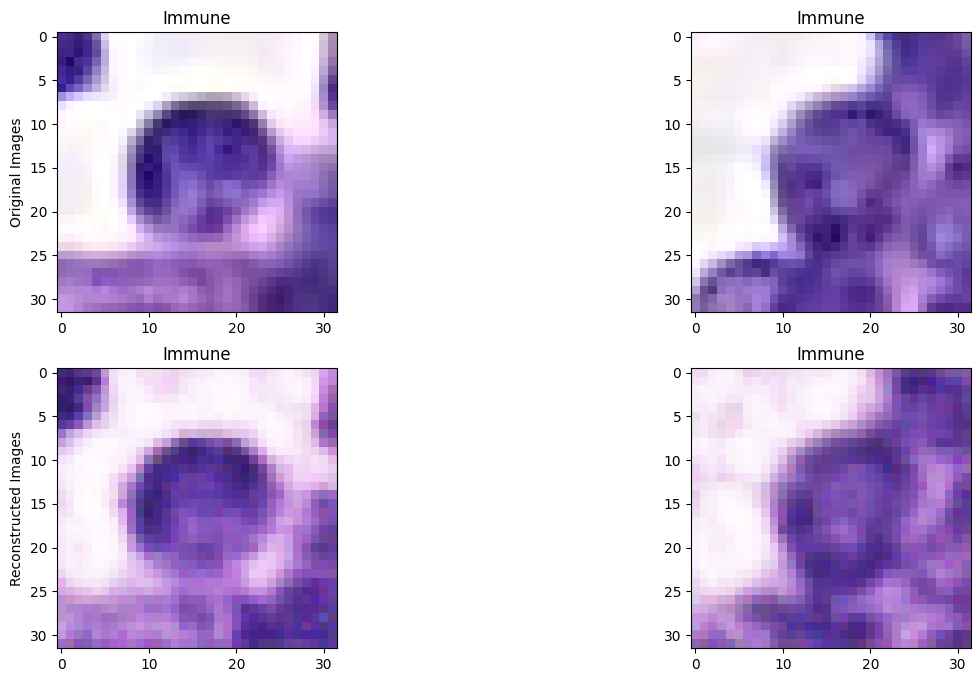

In [18]:
#compare original and reconstructed image from the autoencoder:

figure, ax = plt.subplots(2, 2, figsize=(15, 8))
original_recons_list = []
count_output = 0
for data, label in validation_dataloader:
    if count_output == 2:
        break
    data = data.reshape((data.shape[0], 3, 32, 32))
    x_hat = autoencoder_model(data.to(device))
    #format the data into something imshow can display properly.
    ax[0, count_output].imshow(np.transpose(data[0].to('cpu').detach().numpy(), (1, 2, 0)))
    ax[0, count_output].set_title(labels_dict[label.numpy()[0]])
    ax[1, count_output].imshow(np.transpose(x_hat[0].to('cpu').detach().numpy(), (1, 2, 0)))
    ax[1, count_output].set_title(labels_dict[label.numpy()[0]])
    count_output += 1
ax[0,0].set_ylabel('Original Images')
ax[1,0].set_ylabel('Reconstructed Images')
    

# **Make an Improved CNN model that use the Encoder:**

In [19]:
#construct a new cnn that takes latent vector as  input

class improved_cnn(nn.Module):
    def __init__(self, encoder, latent_dims):
        super(improved_cnn, self).__init__()
        self.encoder = encoder
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(in_features=128,
                                 out_features=64)
        self.linear5 = nn.Linear(in_features=64,
                                 out_features=32)
        self.linear6 = nn.Linear(in_features=32,
                                 out_features=4)

        
    def forward(self, input):
        x_hat, maxpool_indices = self.encoder(input)
        x_hat = x_hat.detach()
        x = self.linear1(x_hat)
        x = Func.relu(x)
        x = self.linear2(x)
        x = Func.relu(x)
        x = self.linear3(x)
        x = Func.relu(x)
        x = self.linear4(x)
        x = Func.relu(x)
        x = self.linear5(x)
        x = Func.relu(x)       
        x = self.linear6(x)
        return x

# **Define a training function for Improved CNN model:**

In [20]:
#training function for improved cnn:

def train_improved_cnn(n_epochs, optimizer, model, device, loss_fn, train_loader, validator, validation_dataloader):
    model = model.to(device)
    validation_loss_list = []
    validation_acc_list = []
    train_loss_list = []
    train_acc_list = []
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        print('Epoch {}, Training loss {}'.format(epoch, float(loss_train)))
        validation_loss, validation_acc = validator(model,
                                                     device,
                                                     validation_dataloader)
        train_loss, train_acc = validator(model,
                                          device,
                                          train_dataloader)
        validation_loss_list.append(validation_loss)
        validation_acc_list.append(validation_acc)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
    return validation_loss_list, validation_acc_list, train_loss_list, train_acc_list
    

# **Define a test function for Improved CNN model:**

In [21]:
#test the improved cnn:

def test_improved_cnn(model, device, test_loader):
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.to(device))
            test_loss += Func.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, 
                                                                                 correct, 
                                                                                 len(test_loader.dataset), 
                                                                                 100. * correct / len(test_loader.dataset)))
    return test_loss,  (100. * correct / len(test_loader.dataset))

# **Train and Test the Improved CNN model:**
since the encoder is already trained it is left out of the training process.

In [22]:
#start the training for improved cnn:
improved_cnn_model = improved_cnn(autoencoder_model.encoder, 1024).to(device)
improved_cnn_adam_optimizer = optim.Adam(improved_cnn_model.parameters(), lr = lr_rate)


improved_cnn_validation_loss_list, improved_cnn_validation_acc_list, improved_cnn_train_loss_list, improved_cnn_train_acc_list = train_improved_cnn(50,
                                                                                                                                                     improved_cnn_adam_optimizer,
                                                                                                                                                     improved_cnn_model,
                                                                                                                                                     device,
                                                                                                                                                     cnn_loss_func,
                                                                                                                                                     train_dataloader,
                                                                                                                                                     test_improved_cnn,
                                                                                                                                                     validation_dataloader)
 

Epoch 1, Training loss 8.2173433303833

Test set: Average loss: -0.0947, Accuracy: 248/340 (73%)


Test set: Average loss: -0.0952, Accuracy: 925/1360 (68%)

Epoch 2, Training loss 6.7377601861953735

Test set: Average loss: -1.3583, Accuracy: 210/340 (62%)


Test set: Average loss: -1.3136, Accuracy: 809/1360 (59%)

Epoch 3, Training loss 4.182775378227234

Test set: Average loss: -3.4431, Accuracy: 245/340 (72%)


Test set: Average loss: -3.3598, Accuracy: 1031/1360 (76%)

Epoch 4, Training loss 3.320471167564392

Test set: Average loss: -4.6334, Accuracy: 261/340 (77%)


Test set: Average loss: -4.7314, Accuracy: 1076/1360 (79%)

Epoch 5, Training loss 2.697044759988785

Test set: Average loss: -6.5932, Accuracy: 298/340 (88%)


Test set: Average loss: -5.9229, Accuracy: 1144/1360 (84%)

Epoch 6, Training loss 2.6025775969028473

Test set: Average loss: -5.6590, Accuracy: 302/340 (89%)


Test set: Average loss: -5.4347, Accuracy: 1147/1360 (84%)

Epoch 7, Training loss 2.36822274327

# **Plot the Validation loss and accuracy for the Improved CNN model:**

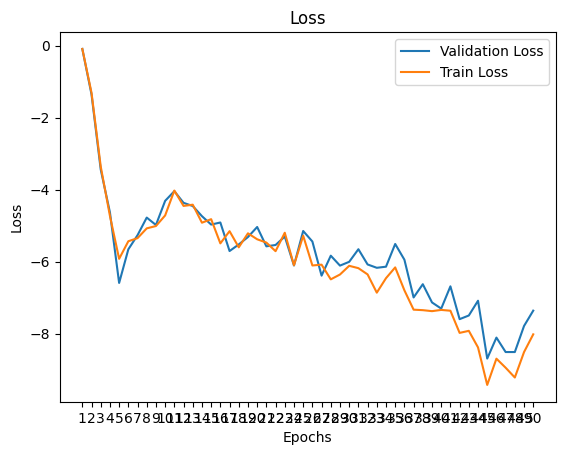

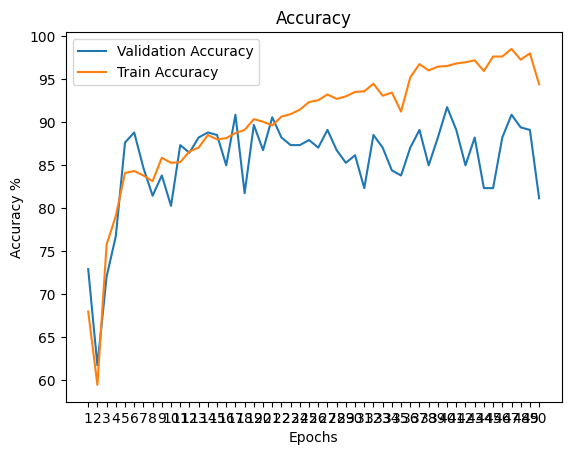

In [23]:
#plot improved cnn validation loss graph:
plot_loss(50, improved_cnn_validation_loss_list, improved_cnn_train_loss_list)

#plot improved cnn validation acc graph:
plot_acc(50, improved_cnn_validation_acc_list, improved_cnn_train_acc_list)

# **Plot the Confusion Matrix for the Improved CNN model on Validation data:**

[[90  6  0  2]
 [ 8 97  2  4]
 [ 0  6 93  0]
 [ 2 14  0 16]]


C:\Users\karthik\AppData\Local\Temp\ipykernel_11244\367963129.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_list)
C:\Users\karthik\AppData\Local\Temp\ipykernel_11244\367963129.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_list)


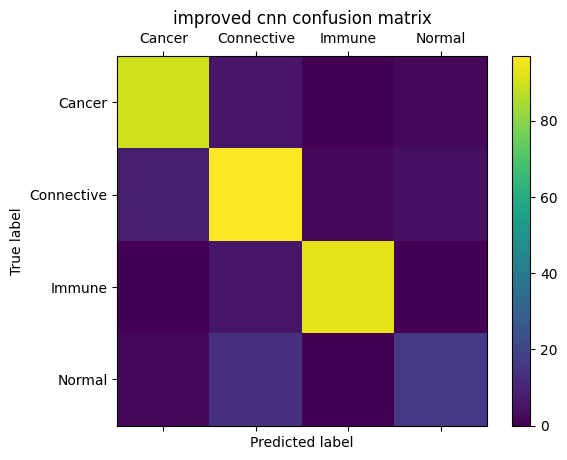

In [24]:
#confusion matrix for improved cnn model:

improved_cnn_true_label = []
improved_cnn_pred_label = []
#get the true label and caculate
#the predicted label and use it to calculate
#the confusion matrix
for data, label in validation_dataset:
    data = data.reshape(1,3,32,32)
    pred_label = torch.argmax(improved_cnn_model(data.to(device)), 1)
    improved_cnn_true_label.append(label)
    improved_cnn_pred_label.append(pred_label.to('cpu').numpy()[0])

classifier_confusion_matrix(improved_cnn_true_label, 
                            improved_cnn_pred_label, 
                            labels_dict, 
                            'improved cnn confusion matrix')

# **Predict the label for the test dataset using Improved CNN model:**

In [25]:
#get predicted label for test dataset:

test_dataset_prediction = {'Id':[], 'Type':[]}

#calulate the predicted label for unlabeled test dataset
#and get the filename for the data. put the filename and data in 
#a dict.
for i, (data, label) in enumerate(test_dataset, 0):
    data = data.reshape((1, 3, 32, 32))
    output = improved_cnn_model(data.to(device))
    labels = torch.argmax(output, 1)
    label_name = labels_dict[labels.tolist()[0]]
    sample_filename, _  = test_dataset.samples[i]
    sample_filename = sample_filename.split('\\')[-1]
    test_dataset_prediction['Id'] += [sample_filename]
    test_dataset_prediction['Type'] += [label_name]


# **Save the result of prediction to a test.csv file:**

In [26]:
#write to csv file:

#convert the dict to a pandas dataframe and use
#pandas to save as test.csv file.
test_dataset_prediction_df = pd.DataFrame(test_dataset_prediction)
test_dataset_prediction_df.to_csv('test.csv', index=False)